# Data

NPZ: cache/encodec_acoustic/items/7cc00e4262dfdfd6154a.npz
D=17 T=87 C=4 bpm=138.0 drummer_id=1
resolved codec: encodec vocab_size: 2049 pad_id: 2048


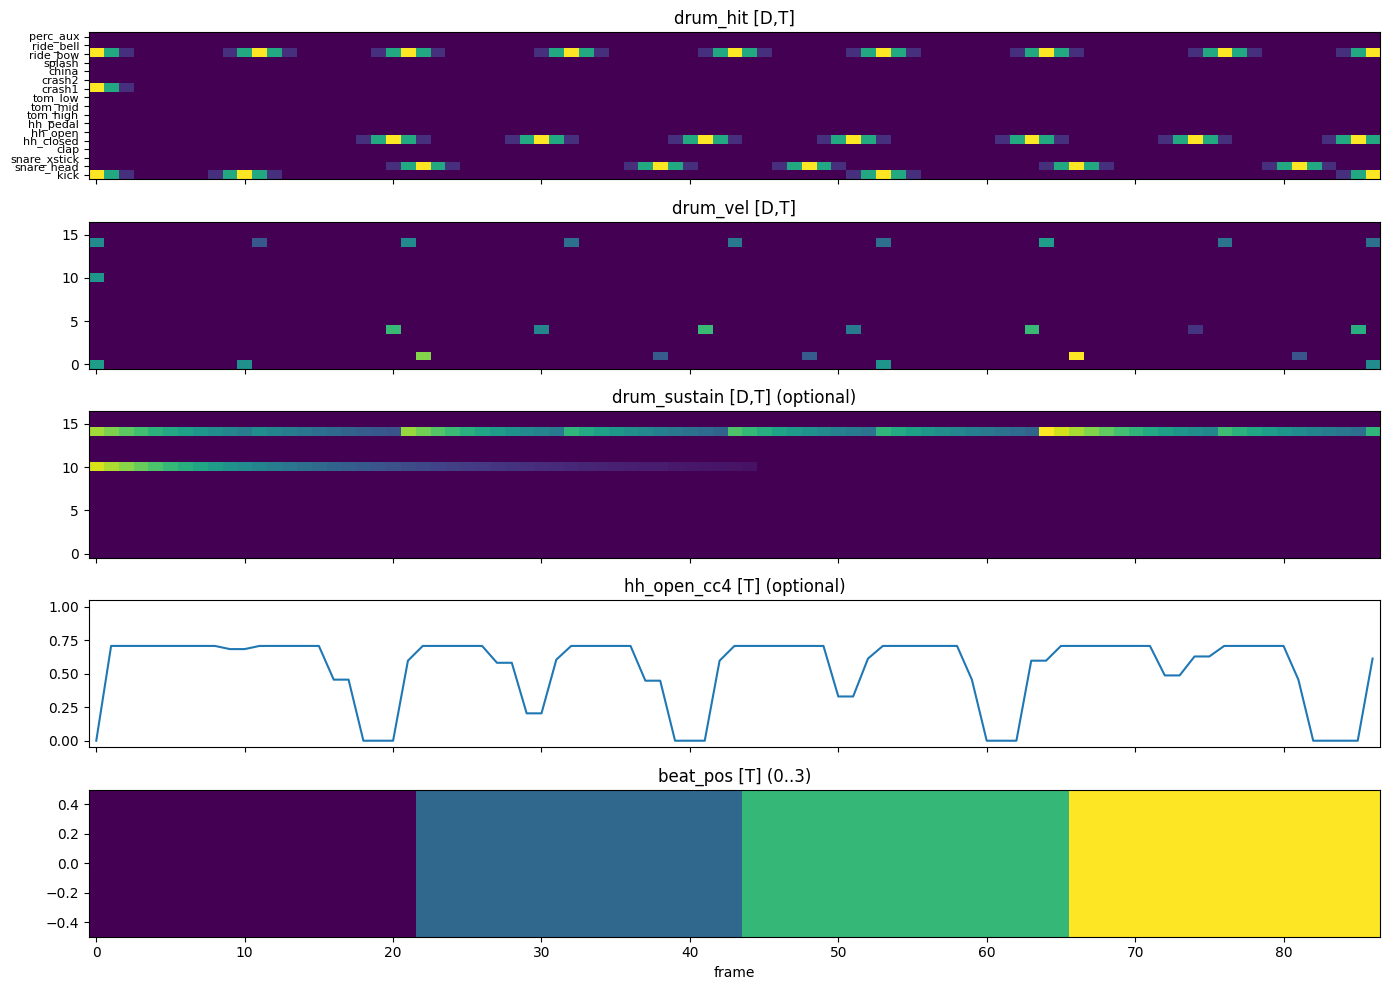

/home/ksoil/.conda/envs/ksoil_torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


used sustain: False used hh_cc4: False
token_acc(masked): 0.31896551724137934 pred shape: (4, 87) tgt shape: (4, 87)


2026-01-28 12:14:21.658116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769595261.674124 1016687 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769595261.679510 1016687 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769595261.693304 1016687 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769595261.693318 1016687 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769595261.693319 1016687 computation_placer.cc:177] computation placer alr

ref_rs: (55652,) gt_rs: (55652,) pr_rs: (55652,)
Original audio (resampled):


Codec reconstruction from ground-truth tokens (encodec) (resampled):


Model prediction decoded (encodec) (resampled):


L1(gt vs ref): 0.0047823903150856495
L1(pred vs ref): 0.01072035450488329


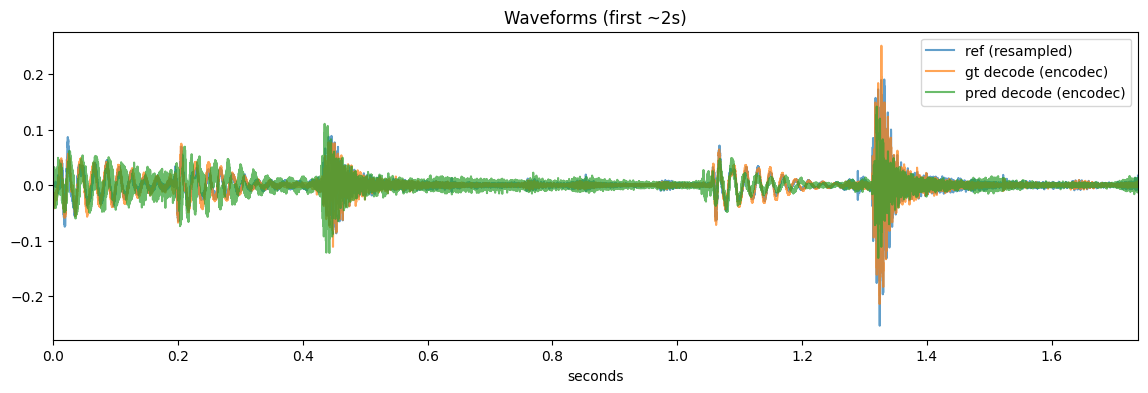

In [1]:
# One cell: load 1 cache item, resolve codec/vocab/pad from cache+ckpt, plot, run, decode, audio + plots
from pathlib import Path
import json, numpy as np, torch

CACHE_DIR = Path("cache/encodec_acoustic")  # xcodec_acoustic, dac_acoustic
CKPT_PATH = Path("artifacts/checkpoints/encodec_small_single_kit.pt") # expressivegrid_to_xcodec, expressivegrid_to_dac
DEVICE = "cuda:0"         # model forward
DECODE_DEVICE = "cuda:0"  # codec decode (set to "cpu" if VRAM is tight)
EVAL_SR = 32000

# --- pick 1 item ---
manifest = sorted(CACHE_DIR.glob("manifest_midigroove_test_*.jsonl"))[0]
rec = json.loads(manifest.read_text().splitlines()[0])
npz_path = Path(rec["npz"])
print("NPZ:", npz_path)

with np.load(npz_path, allow_pickle=False) as d:
    ex = {k: np.asarray(d[k]) for k in d.files}

# --- load conditioning + targets ---
drum_hit = ex["drum_hit"].astype(np.float32)                                # [D,T]
drum_vel = ex.get("drum_vel", np.zeros_like(drum_hit)).astype(np.float32)   # [D,T]
drum_sus = ex.get("drum_sustain", np.zeros_like(drum_hit)).astype(np.float32)  # [D,T]
hh_cc4   = ex.get("hh_open_cc4", np.zeros((drum_hit.shape[1],), np.float32)).astype(np.float32)  # [T]
beat_pos = ex["beat_pos"].astype(np.int64)                                  # [T]
bpm = float(ex.get("bpm", 120.0))
drummer_id = int(ex.get("drummer_id", 0))
tgt = ex["tgt"].astype(np.int64)                                            # [C,T]
D, T = drum_hit.shape
C = int(tgt.shape[0])
print(f"D={D} T={T} C={C} bpm={bpm} drummer_id={drummer_id}")

# --- resolve codec from cache semantics (fallback to ckpt cfg) ---
cache_sem = json.loads(str(ex.get("semantics", np.asarray("{}")).item() or "{}"))
cache_codec = str(cache_sem.get("encoder", "") or "").strip().lower() or None

from midigroove_poc import expressivegrid as eg
ckpt = torch.load(CKPT_PATH, map_location="cpu")
cfg = ckpt.get("cfg", {}) if isinstance(ckpt.get("cfg", {}), dict) else {}
ckpt_codec = str(cfg.get("encoder_model", "") or "").strip().lower() or None
codec = cache_codec or ckpt_codec or "encodec"

# --- resolve vocab_size / pad_id from ckpt (new) or infer from head (old) ---
num_codebooks = int(ckpt["num_codebooks"])
state = ckpt["model"]
vocab_size = int(cfg.get("vocab_size", 0) or 0)
if vocab_size <= 0:
    vs = eg._infer_vocab_size_from_state_dict(state, num_codebooks=num_codebooks)
    vocab_size = int(vs) if vs is not None else int(eg._vocab_size_for_codebook(eg._default_codebook_size_for_encoder(codec)))
pad_id = int(cfg.get("pad_id", vocab_size - 1 if vocab_size > 1 else 2048))

print("resolved codec:", codec, "vocab_size:", vocab_size, "pad_id:", pad_id)

# --- plotting inputs (always show all lanes) ---
try:
    import matplotlib.pyplot as plt
except Exception as e:
    raise RuntimeError("Install matplotlib in this env (e.g. `pip install matplotlib`)") from e

from data.midigroove_encodec_dataset import CHANNELS
fig, axs = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

axs[0].imshow(drum_hit, aspect="auto", origin="lower", interpolation="nearest")
axs[0].set_title("drum_hit [D,T]")
axs[0].set_yticks(range(len(CHANNELS)))
axs[0].set_yticklabels(CHANNELS, fontsize=8)

axs[1].imshow(drum_vel, aspect="auto", origin="lower", interpolation="nearest")
axs[1].set_title("drum_vel [D,T]")

axs[2].imshow(drum_sus, aspect="auto", origin="lower", interpolation="nearest")
axs[2].set_title("drum_sustain [D,T] (optional)")

axs[3].plot(hh_cc4)
axs[3].set_ylim(-0.05, 1.05)
axs[3].set_title("hh_open_cc4 [T] (optional)")

axs[4].imshow(beat_pos[None, :], aspect="auto", origin="lower", interpolation="nearest", vmin=0, vmax=3)
axs[4].set_title("beat_pos [T] (0..3)")
axs[4].set_xlabel("frame")

plt.tight_layout()
plt.show()

# --- build input grid respecting ckpt feature flags ---
include_sustain = bool(cfg.get("include_sustain", False))
include_hh_cc4 = bool(cfg.get("include_hh_cc4", False))

pieces = [drum_hit, drum_vel]
if include_sustain:
    pieces.append(drum_sus)
if include_hh_cc4:
    pieces.append(hh_cc4[None, :])

grid = np.concatenate(pieces, axis=0).astype(np.float32)  # [F,T]
in_dim = int(ckpt["in_dim"])
assert grid.shape[0] == in_dim and grid.shape[1] == T, (grid.shape, in_dim, T)

# --- run checkpoint -> predicted tokens ---
cfg2 = dict(cfg)
cfg2.setdefault("encoder_model", codec)
cfg2["vocab_size"] = int(vocab_size)
cfg2["pad_id"] = int(pad_id)

model = eg._build_model(num_codebooks=num_codebooks, in_dim=in_dim, cfg=cfg2)
model.load_state_dict(state, strict=True)
model.to(torch.device(DEVICE)).eval()

grid_t = torch.from_numpy(grid).unsqueeze(0).to(DEVICE)            # [1,F,T]
beat_pos_t = torch.from_numpy(beat_pos).unsqueeze(0).to(DEVICE)    # [1,T]
bpm_t = torch.tensor([bpm], dtype=torch.float32, device=DEVICE)    # [1]
drummer_id_t = torch.tensor([drummer_id], dtype=torch.long, device=DEVICE)  # [1]
valid_mask_t = torch.ones((1, T), dtype=torch.bool, device=DEVICE)

with torch.inference_mode():
    logits = model(grid=grid_t, beat_pos=beat_pos_t, bpm=bpm_t, drummer_id=drummer_id_t, valid_mask=valid_mask_t)  # [1,C,T,V]
    pred = logits.argmax(dim=-1).squeeze(0).to(torch.long).cpu()  # [C,T]

tgt_t = torch.from_numpy(tgt).to(torch.long)  # [C,T]
mask = tgt_t.ne(pad_id)
tok_acc_masked = float(((pred == tgt_t) & mask).sum().item() / max(1, mask.sum().item()))
print("used sustain:", include_sustain, "used hh_cc4:", include_hh_cc4)
print("token_acc(masked):", tok_acc_masked, "pred shape:", tuple(pred.shape), "tgt shape:", tuple(tgt_t.shape))

# for decoding: map PAD -> 0
pred_clean = torch.where(pred == pad_id, torch.zeros_like(pred), pred)
tgt_clean = torch.where(tgt_t == pad_id, torch.zeros_like(tgt_t), tgt_t)

# --- decode audio (prediction vs gt tokens) and compare to original segment ---
from IPython.display import Audio, display
from data.codecs import decode_tokens_to_audio
from midigroove_poc.eval import _load_audio_segment, _resample_linear

audio_path = Path(str(ex["audio_path"].item()))
sr_native = int(ex["sr"].item())
start_sec = float(ex["start_sec"].item())
window_seconds = float(ex["window_seconds"].item())
start_sample = int(round(start_sec * sr_native))
window_samples = int(round(window_seconds * sr_native))

ref, sr_ref = _load_audio_segment(audio_path, start_sample=start_sample, num_samples=window_samples)
ref_rs = _resample_linear(ref, sr_ref, EVAL_SR)

audio_gt_b1, sr_gt = decode_tokens_to_audio(tgt_clean, encoder_model=codec, device=DECODE_DEVICE)
audio_pr_b1, sr_pr = decode_tokens_to_audio(pred_clean, encoder_model=codec, device=DECODE_DEVICE)
gt_rs = _resample_linear(audio_gt_b1[0], sr_gt, EVAL_SR)
pr_rs = _resample_linear(audio_pr_b1[0], sr_pr, EVAL_SR)

N = min(ref_rs.size, gt_rs.size, pr_rs.size)
ref_rs, gt_rs, pr_rs = ref_rs[:N], gt_rs[:N], pr_rs[:N]

print("ref_rs:", ref_rs.shape, "gt_rs:", gt_rs.shape, "pr_rs:", pr_rs.shape)

print("Original audio (resampled):")
display(Audio(ref_rs, rate=EVAL_SR))
print(f"Codec reconstruction from ground-truth tokens ({codec}) (resampled):")
display(Audio(gt_rs, rate=EVAL_SR))
print(f"Model prediction decoded ({codec}) (resampled):")
display(Audio(pr_rs, rate=EVAL_SR))

# --- waveform comparison plots ---
import numpy as np
def l1(a, b): return float(np.mean(np.abs(a - b)))
print("L1(gt vs ref):", l1(gt_rs, ref_rs))
print("L1(pred vs ref):", l1(pr_rs, ref_rs))

t = np.arange(N) / float(EVAL_SR)
plt.figure(figsize=(14,4))
plt.plot(t, ref_rs, label="ref (resampled)", alpha=0.7)
plt.plot(t, gt_rs, label=f"gt decode ({codec})", alpha=0.7)
plt.plot(t, pr_rs, label=f"pred decode ({codec})", alpha=0.7)
plt.xlim(0, min(t[-1], 2.0))
plt.legend()
plt.title("Waveforms (first ~2s)")
plt.xlabel("seconds")
plt.show()


In [ ]:
df['kit_name'].value_counts().sort_values(ascending=False)

# Eval

,RMSE $\downarrow$,MAE (L1) $\downarrow$,MR-STFT SC $\downarrow$,Env RMS corr $\uparrow$,TTER dB MAE $\downarrow$,Onset precision $\uparrow$,Onset recall $\uparrow$,Onset F1 $\uparrow$
model,,,,,,,,
dac_small_single_kit,0.0184 ± 0.0094,0.0095 ± 0.0054,0.982 ± 0.085,0.580 ± 0.235,1.435 ± 1.245,0.734 ± 0.171,0.585 ± 0.159,0.625 ± 0.113
encodec_small_single_kit,0.0201 ± 0.0106,0.0100 ± 0.0058,0.842 ± 0.160,0.690 ± 0.228,1.289 ± 1.221,0.767 ± 0.174,0.531 ± 0.152,0.606 ± 0.123
xcodec_small_single_kit,0.0305 ± 0.0176,0.0161 ± 0.0110,1.357 ± 0.702,0.552 ± 0.242,1.917 ± 1.598,0.758 ± 0.173,0.587 ± 0.159,0.634 ± 0.115


Wrote: artifacts/eval/small_one_kit/paper_figs


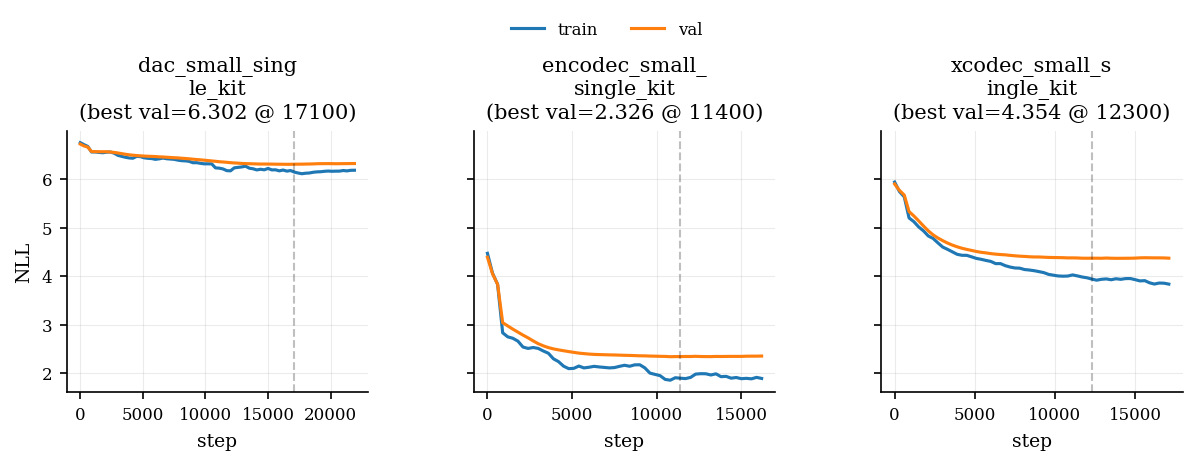

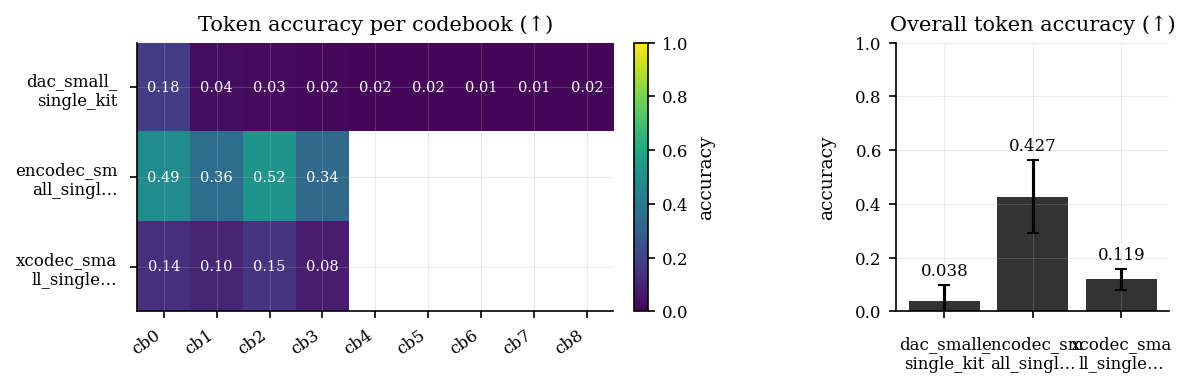

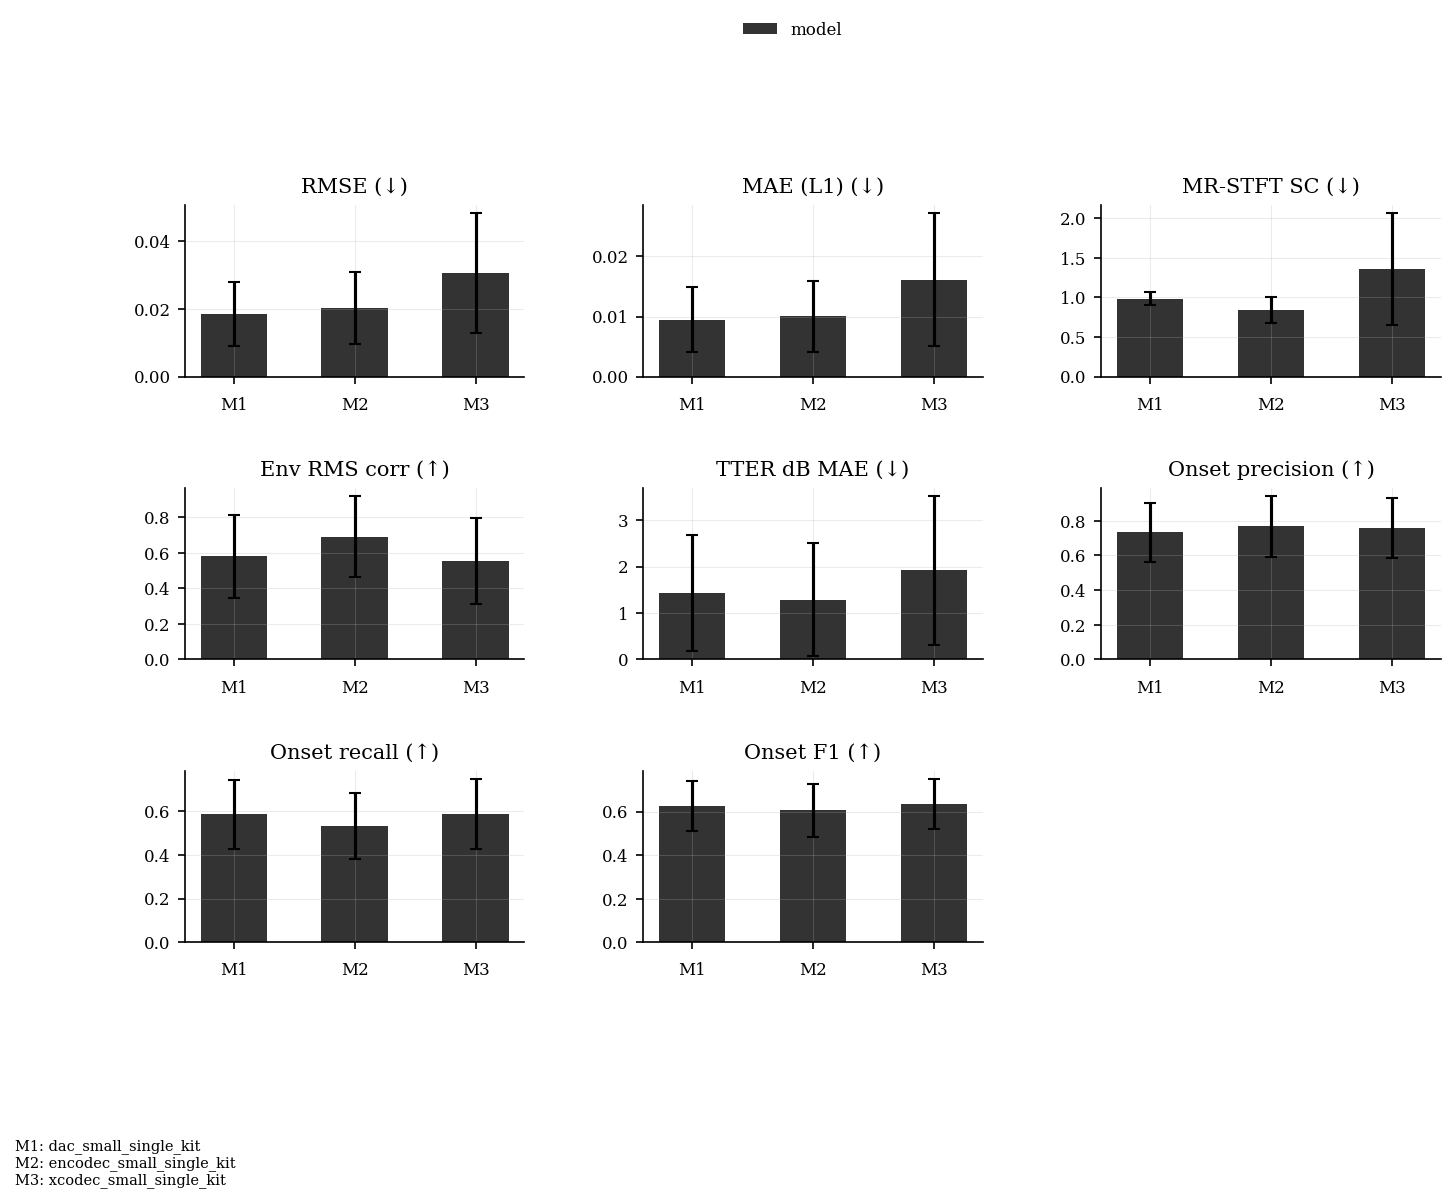

In [3]:
# Notebook snippet: plots + (optional) oracle-paired table (±) + arrows in plot + LaTeX
# FIXES:
# - keep checkpoint-derived names (no DAC/EnCodec/XCodec override)
# - make checkpoint-derived names fit in plots (wrap + ellipsis, no overlap)
# - eval.py no longer outputs FAD / SI-SDR / onset timing; using:
#   RMSE, MAE (L1), MR-STFT SC, envelope RMS corr, TTER(dB) MAE, onset P/R/F1 (MIDI-referenced)
# - AUTOMATION: if no *_oracle systems exist, table/plots omit oracle columns/bars automatically

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

OUT_DIR = Path("artifacts/eval/small_one_kit")  # <-- change
FIG_DIR = OUT_DIR / "paper_figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def set_paper_style():
    plt.rcParams.update(
        {
            "figure.dpi": 150,
            "savefig.dpi": 300,
            "font.size": 9,
            "font.family": "DejaVu Serif",
            "axes.titlesize": 10,
            "axes.labelsize": 9,
            "legend.fontsize": 8,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.5,
        }
    )

def load_eval(out_dir: Path):
    summary = json.loads((out_dir / "summary.json").read_text(encoding="utf-8"))
    items = pd.read_csv(out_dir / "items.csv")
    return summary, items

def _paper_model_label_from_stem(stem: str) -> str:
    s = str(stem)
    for prefix in ("expressivegrid_to_", "expressivegrid-to-", "eg_", "eg-"):
        if s.startswith(prefix):
            s = s[len(prefix):]
    return s.replace("__", "_").strip("_")

def _fit_xtick_label(s: str, *, max_chars: int = 22, wrap_at: int = 12) -> str:
    s = str(s)
    if len(s) > max_chars:
        s = s[: max_chars - 1] + "…"
    if len(s) > wrap_at:
        return "\n".join(textwrap.wrap(s, width=wrap_at))
    return s

def base_systems(summary: dict) -> list[str]:
    return sorted([k for k in summary["systems"].keys() if not k.endswith(("_oracle", "_random"))])

def ckpt_from_summary(summary: dict, system: str) -> Path | None:
    p = summary["systems"].get(system, {}).get("ckpt")
    return Path(p) if isinstance(p, str) and p else None

def label_for_base(summary: dict, base: str) -> str:
    ckpt = ckpt_from_summary(summary, base)
    return _paper_model_label_from_stem(ckpt.stem) if ckpt is not None else base

def find_train_metrics_csv(summary: dict, system: str) -> Path | None:
    ckpt = ckpt_from_summary(summary, system)
    if ckpt is None:
        return None
    p = Path(str(ckpt) + ".metrics.csv")
    return p if p.is_file() else None

def plot_training_grid(summary: dict, systems, labels, fig_dir: Path, smoothing_window: int = 5):
    set_paper_style()
    n = len(systems)
    fig, axes = plt.subplots(1, n, figsize=(3.2 * n, 2.6), sharey=True)
    if n == 1:
        axes = [axes]

    handles = None
    leg_labels = None

    for ax, sys, lab in zip(axes, systems, labels):
        lab_fit = _fit_xtick_label(lab, max_chars=28, wrap_at=14)

        p = find_train_metrics_csv(summary, sys)
        if p is None:
            ax.set_title(f"{lab_fit} (no train log)")
            ax.set_axis_off()
            continue

        df = pd.read_csv(p).sort_values("step")
        best_val = float(df["val_loss"].min()) if "val_loss" in df.columns and len(df) else float("nan")
        best_step = int(df.loc[df["val_loss"].idxmin(), "step"]) if "val_loss" in df.columns and len(df) else None

        x = df["step"].to_numpy()
        tr = df["train_loss"].to_numpy()
        va = df["val_loss"].to_numpy()

        if smoothing_window and smoothing_window > 1 and len(df) >= smoothing_window:
            tr = pd.Series(tr).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()
            va = pd.Series(va).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()

        l1, = ax.plot(x, tr, label="train", color="C0")
        l2, = ax.plot(x, va, label="val", color="C1")
        if handles is None:
            handles = [l1, l2]
            leg_labels = ["train", "val"]

        if best_step is not None:
            ax.axvline(best_step, color="k", alpha=0.25, linewidth=1.0, linestyle="--")

        ax.set_title(f"{lab_fit}\n(best val={best_val:.3f}" + (f" @ {best_step}" if best_step is not None else "") + ")")
        ax.set_xlabel("step")
        ax.set_ylabel("NLL" if ax is axes[0] else "")

    if handles is not None:
        fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.10))

    fig.subplots_adjust(top=0.78, wspace=0.35)
    fig.savefig(fig_dir / "training_curves_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "training_curves_grid.png", bbox_inches="tight")
    return fig

def token_acc_summary(items: pd.DataFrame):
    cb_cols = sorted(
        [c for c in items.columns if c.startswith("token_acc_cb")],
        key=lambda s: int(s.replace("token_acc_cb", "")),
    )
    overall = items.groupby("system")["token_acc"].agg(["mean", "std", "count"]).rename(columns={"count": "n"})
    per_cb_mean = items.groupby("system")[cb_cols].mean()
    per_cb_std = items.groupby("system")[cb_cols].std()
    return overall, per_cb_mean, per_cb_std, cb_cols

def _short_model_label(s: str) -> str:
    s = str(s)
    for prefix in ("expressivegrid_to_", "expressivegrid-to-", "eg_", "eg-"):
        if s.startswith(prefix):
            s = s[len(prefix):]
    return s.replace("__", "_").strip("_")

def _text_color_for_value(v: float) -> str:
    return "white" if np.isfinite(v) and v < 0.55 else "black"

def plot_token_acc(systems, labels, overall, per_cb_mean, cb_cols, fig_dir: Path, *, heatmap_decimals: int = 2, bar_decimals: int = 3):
    set_paper_style()
    ylabels = [_fit_xtick_label(_short_model_label(l), max_chars=20, wrap_at=10) for l in labels]
    xlabels = ylabels
    heat = per_cb_mean.reindex(systems)[cb_cols]

    fig = plt.figure(figsize=(8.6, 3.2))
    gs = fig.add_gridspec(1, 2, width_ratios=[2.1, 1.1])
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    arr = heat.to_numpy()
    im = ax0.imshow(arr, aspect="auto", vmin=0.0, vmax=1.0, cmap="viridis")
    ax0.set_title("Token accuracy per codebook (↑)")
    ax0.set_yticks(range(len(systems)))
    ax0.set_yticklabels(ylabels)
    ax0.set_xticks(range(len(cb_cols)))
    ax0.set_xticklabels([c.replace("token_acc_cb", "cb") for c in cb_cols], rotation=35, ha="right")
    ax0.tick_params(axis="y", pad=6)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            v = arr[i, j]
            if not np.isfinite(v):
                continue
            ax0.text(j, i, f"{v:.{heatmap_decimals}f}", ha="center", va="center", fontsize=7, color=_text_color_for_value(float(v)))

    cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
    cbar.set_label("accuracy")

    o = overall.reindex(systems)
    x = np.arange(len(systems))
    means = o["mean"].to_numpy()
    stds = o["std"].to_numpy()
    bars = ax1.bar(x, means, yerr=stds, capsize=3, color="0.2")
    ax1.set_title("Overall token accuracy (↑)")
    ax1.set_ylim(0.0, 1.0)
    ax1.set_xticks(x)
    ax1.set_xticklabels(xlabels, rotation=0, ha="center")
    ax1.set_ylabel("accuracy", labelpad=18)
    ax1.yaxis.set_label_coords(-0.22, 0.5)
    ax1.tick_params(axis="x", pad=8)

    for b, m, s in zip(bars, means, stds):
        if not np.isfinite(m):
            continue
        y = float(m) + (float(s) if np.isfinite(s) else 0.0) + 0.02
        ax1.text(b.get_x() + b.get_width() / 2.0, min(0.98, y), f"{float(m):.{bar_decimals}f}", ha="center", va="bottom", fontsize=8, color="black")

    fig.subplots_adjust(left=0.18, bottom=0.32, right=0.98, wspace=0.60)
    fig.savefig(fig_dir / "token_accuracy_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "token_accuracy_grid.png", bbox_inches="tight")
    return fig

# ---------- Oracle-aware audio table/plots ----------

_METRICS = [
    ("rmse",             "RMSE",                 "down", 4),
    ("mae",              "MAE (L1)",             "down", 4),
    ("mr_stft_sc",       "MR-STFT SC",           "down", 3),
    ("env_rms_corr",     "Env RMS corr",         "up",   3),
    ("tter_db_mae",      "TTER dB MAE",          "down", 3),
    ("onset_precision",  "Onset precision",      "up",   3),
    ("onset_recall",     "Onset recall",         "up",   3),
    ("onset_f1",         "Onset F1",             "up",   3),
]

def _arrow_tex(direction: str) -> str:
    return r"$\uparrow$" if direction == "up" else r"$\downarrow$"

def _fmt_mean_std(v, *, decimals: int) -> str:
    if isinstance(v, dict) and "mean" in v:
        m = v.get("mean", None)
        s = v.get("std", None)
        if isinstance(m, (int, float)) and np.isfinite(m):
            if isinstance(s, (int, float)) and np.isfinite(s):
                return f"{m:.{decimals}f} ± {s:.{decimals}f}"
            return f"{m:.{decimals}f}"
    if isinstance(v, (int, float)) and np.isfinite(v):
        return f"{float(v):.{decimals}f}"
    return ""

def _get_metric(summary: dict, system: str, key: str):
    return summary["systems"].get(system, {}).get(key, None)

def has_any_oracle(summary: dict, bases: list[str]) -> bool:
    return any(f"{b}_oracle" in summary.get("systems", {}) for b in bases)

def oracle_aware_table(summary: dict, bases: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    show_oracle = has_any_oracle(summary, bases)

    rows_pretty = []
    rows_csv = []

    for b in bases:
        o = f"{b}_oracle"
        has_oracle = show_oracle and (o in summary["systems"])

        row_pretty = {"model": label_for_base(summary, b)}
        row_csv = {"model": label_for_base(summary, b)}

        for key, disp, direction, dec in _METRICS:
            arrow_t = _arrow_tex(direction)
            v_b = _get_metric(summary, b, key)
            row_pretty[f"{disp} {arrow_t}"] = _fmt_mean_std(v_b, decimals=dec)
            row_csv[key] = _fmt_mean_std(v_b, decimals=dec)

            if show_oracle:
                v_o = _get_metric(summary, o, key) if has_oracle else None
                row_pretty[f"{disp} (oracle) {arrow_t}"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""
                row_csv[f"{key}_oracle"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""

        rows_pretty.append(row_pretty)
        rows_csv.append(row_csv)

    tbl_pretty = pd.DataFrame(rows_pretty).set_index("model")
    tbl_csv = pd.DataFrame(rows_csv).set_index("model")
    return tbl_pretty, tbl_csv

def plot_audio_metrics_oracle_aware(summary: dict, bases: list[str], fig_dir: Path):
    set_paper_style()

    show_oracle = has_any_oracle(summary, bases)

    full = [label_for_base(summary, b) for b in bases]
    short = [f"M{i+1}" for i in range(len(bases))]

    map_lines = ["Model ID mapping:"]
    for s, f in zip(short, full):
        map_lines.append(f"  {s}: {f}")
    (fig_dir / "model_id_mapping.txt").write_text("\n".join(map_lines) + "\n", encoding="utf-8")

    x = np.arange(len(bases))

    n_metrics = len(_METRICS)
    ncols = 3
    nrows = int(np.ceil(n_metrics / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6 * ncols, 2.6 * nrows), squeeze=False)

    for idx, (key, disp, direction, _dec) in enumerate(_METRICS):
        ax = axes[idx // ncols][idx % ncols]
        arrow = "↑" if direction == "up" else "↓"

        means_b, stds_b = [], []
        means_o, stds_o = [], []

        def _ms(v):
            if isinstance(v, dict) and isinstance(v.get("mean"), (int, float)) and np.isfinite(v["mean"]):
                m = float(v["mean"])
                s = float(v.get("std")) if isinstance(v.get("std"), (int, float)) and np.isfinite(v.get("std")) else 0.0
                return m, s
            if isinstance(v, (int, float)) and np.isfinite(v):
                return float(v), 0.0
            return np.nan, 0.0

        for b in bases:
            o = f"{b}_oracle"
            vb = _get_metric(summary, b, key)
            mb, sb = _ms(vb)
            means_b.append(mb); stds_b.append(sb)

            if show_oracle and (o in summary["systems"]):
                vo = _get_metric(summary, o, key)
                mo, so = _ms(vo)
            else:
                mo, so = np.nan, 0.0
            means_o.append(mo); stds_o.append(so)

        means_b = np.asarray(means_b, dtype=float)
        stds_b = np.asarray(stds_b, dtype=float)

        ax.set_title(f"{disp} ({arrow})")
        ax.set_xticks(x)
        ax.set_xticklabels(short, rotation=0, ha="center")
        ax.tick_params(axis="x", pad=6)

        if show_oracle:
            means_o = np.asarray(means_o, dtype=float)
            stds_o = np.asarray(stds_o, dtype=float)
            w = 0.38
            ax.bar(x - w/2, means_b, w, yerr=stds_b, capsize=3, label="model", color="0.2")
            ax.bar(x + w/2, means_o, w, yerr=stds_o, capsize=3, label="oracle", color="0.6")
        else:
            ax.bar(x, means_b, 0.55, yerr=stds_b, capsize=3, label="model", color="0.2")

    for j in range(n_metrics, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    handles, leg_labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=len(leg_labels), bbox_to_anchor=(0.5, 1.02))

    map_text = "\n".join([f"{s}: {f}" for s, f in zip(short, full)])
    fig.text(0.02, 0.01, map_text, ha="left", va="bottom", fontsize=7)

    fig.subplots_adjust(top=0.85, hspace=0.65, wspace=0.35, bottom=0.22)
    fig.savefig(fig_dir / "audio_metrics_bars.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "audio_metrics_bars.png", bbox_inches="tight")
    return fig

# ---- run ----
summary, items = load_eval(OUT_DIR)
bases = base_systems(summary)

plot_training_grid(summary, bases, [label_for_base(summary, b) for b in bases], FIG_DIR, smoothing_window=5)

overall, per_cb_mean, per_cb_std, cb_cols = token_acc_summary(items)
plot_token_acc(bases, [label_for_base(summary, b) for b in bases], overall, per_cb_mean, cb_cols, FIG_DIR)

tbl_pretty, tbl_csv = oracle_aware_table(summary, bases)
display(tbl_pretty)

# Filenames reflect whether oracle was present
_oracle_suffix = "_with_oracle" if has_any_oracle(summary, bases) else "_no_oracle"

tbl_csv.to_csv(FIG_DIR / f"audio_table{_oracle_suffix}.csv")
tbl_pretty.to_latex(FIG_DIR / f"audio_table{_oracle_suffix}.tex", escape=False)
tbl_pretty.to_csv(FIG_DIR / f"audio_table_pretty{_oracle_suffix}.csv")

plot_audio_metrics_oracle_aware(summary, bases, FIG_DIR)

print("Wrote:", FIG_DIR)

,RMSE $\downarrow$,RMSE (oracle) $\downarrow$,MAE (L1) $\downarrow$,MAE (L1) (oracle) $\downarrow$,MR-STFT SC $\downarrow$,MR-STFT SC (oracle) $\downarrow$,Env RMS corr $\uparrow$,Env RMS corr (oracle) $\uparrow$,TTER dB MAE $\downarrow$,TTER dB MAE (oracle) $\downarrow$,Onset precision $\uparrow$,Onset precision (oracle) $\uparrow$,Onset recall $\uparrow$,Onset recall (oracle) $\uparrow$,Onset F1 $\uparrow$,Onset F1 (oracle) $\uparrow$
model,,,,,,,,,,,,,,,,
dac_allkits,0.0187 ± 0.0106,0.0060 ± 0.0030,0.0097 ± 0.0062,0.0029 ± 0.0016,1.042 ± 0.190,0.243 ± 0.089,0.597 ± 0.257,0.995 ± 0.007,2.061 ± 1.667,0.316 ± 0.578,0.768 ± 0.171,0.730 ± 0.210,0.619 ± 0.152,0.557 ± 0.179,0.661 ± 0.114,0.609 ± 0.158
encodec_allkits,0.0195 ± 0.0110,0.0092 ± 0.0040,0.0101 ± 0.0065,0.0048 ± 0.0023,0.827 ± 0.151,0.397 ± 0.102,0.708 ± 0.214,0.972 ± 0.040,1.525 ± 1.315,0.691 ± 0.766,0.775 ± 0.170,0.740 ± 0.208,0.562 ± 0.153,0.542 ± 0.174,0.630 ± 0.123,0.605 ± 0.156
xcodec_allkits,0.0328 ± 0.0189,0.0133 ± 0.0072,0.0171 ± 0.0116,0.0061 ± 0.0037,1.659 ± 0.857,0.475 ± 0.125,0.558 ± 0.256,0.961 ± 0.035,2.295 ± 2.016,0.399 ± 0.357,0.751 ± 0.174,0.711 ± 0.201,0.603 ± 0.162,0.588 ± 0.172,0.641 ± 0.118,0.620 ± 0.149


n RMSE $\downarrow$  \
kit               model                                    
60s Rock          dac_allkits       60   0.0132 ± 0.0066   
                  encodec_allkits   60   0.0140 ± 0.0069   
                  xcodec_allkits    60   0.0201 ± 0.0078   
808 Simple        dac_allkits       90   0.0163 ± 0.0096   
                  encodec_allkits   90   0.0176 ± 0.0108   
...                                ...               ...   
Warmer Funk       encodec_allkits   54   0.0189 ± 0.0110   
                  xcodec_allkits    54   0.0334 ± 0.0222   
West Coast (FUNK) dac_allkits      108   0.0133 ± 0.0058   
                  encodec_allkits  108   0.0139 ± 0.0065   
                  xcodec_allkits   108   0.0189 ± 0.0108   

                                  RMSE (oracle) $\downarrow$  \
kit               model                                        
60s Rock          dac_allkits                                  
                  encodec_allkits                              
                  xcodec_allkits                               
808 Simple        dac_allkits                                  
                  encodec_allkits                              
...                                                      ...   
Warmer Funk       encodec_allkits                              
                  xcodec_allkits                               
West Coast (FUNK) dac_allkits                                  
                  encodec_allkits                              
                  xcodec_allkits                               

                                  MAE (L1) $\downarrow$  \
kit               model                                   
60s Rock          dac_allkits           0.0060 ± 0.0037   
                  encodec_allkits       0.0064 ± 0.0040   
                  xcodec_allkits        0.0089 ± 0.0052   
808 Simple        dac_allkits           0.0108 ± 0.0071   
                  encodec_allkits       0.0116 ± 0.0078   
...                                                 ...   
Warmer Funk       encodec_allkits       0.0087 ± 0.0062   
                  xcodec_allkits        0.0147 ± 0.0110   
West Coast (FUNK) dac_allkits           0.0062 ± 0.0030   
                  encodec_allkits       0.0064 ± 0.0031   
                  xcodec_allkits        0.0084 ± 0.0047   

                                  MAE (L1) (oracle) $\downarrow$  \
kit               model                                            
60s Rock          dac_allkits                                      
                  encodec_allkits                                  
                  xcodec_allkits                                   
808 Simple        dac_allkits                                      
                  encodec_allkits                                  
...                                                          ...   
Warmer Funk       encodec_allkits                                  
                  xcodec_allkits                                   
West Coast (FUNK) dac_allkits                                      
                  encodec_allkits                                  
                  xcodec_allkits                                   

                                  MR-STFT SC $\downarrow$  \
kit               model                                     
60s Rock          dac_allkits               0.992 ± 0.069   
                  encodec_allkits           0.886 ± 0.140   
                  xcodec_allkits            1.353 ± 0.517   
808 Simple        dac_allkits               0.979 ± 0.038   
                  encodec_allkits           0.828 ± 0.085   
...                                                   ...   
Warmer Funk       encodec_allkits           0.924 ± 0.175   
                  xcodec_allkits            1.907 ± 0.887   
West Coast (FUNK) dac_allkits               1.047 ± 0.158   
                  encodec_allkits           0.832 ± 0.130   
                  xcodec_allkits      

,n,overall_winner,overall_rank_sum,rmse_winner,rmse_best,mae_winner,mae_best,mr_stft_sc_winner,mr_stft_sc_best,env_rms_corr_winner,env_rms_corr_best,tter_db_mae_winner,tter_db_mae_best,onset_precision_winner,onset_precision_best,onset_recall_winner,onset_recall_best,onset_f1_winner,onset_f1_best
kit,,,,,,,,,,,,,,,,,,,
60s Rock,60,dac_allkits,15.0,dac_allkits,0.0132,dac_allkits,0.0060,encodec_allkits,0.886,encodec_allkits,0.669,xcodec_allkits,1.330,encodec_allkits,0.754,xcodec_allkits,0.598,xcodec_allkits,0.624
808 Simple,90,dac_allkits,14.0,dac_allkits,0.0163,dac_allkits,0.0108,encodec_allkits,0.828,encodec_allkits,0.552,encodec_allkits,2.718,encodec_allkits,0.849,xcodec_allkits,0.674,xcodec_allkits,0.710
909 Simple,60,dac_allkits,12.0,dac_allkits,0.0244,dac_allkits,0.0134,encodec_allkits,0.820,encodec_allkits,0.770,encodec_allkits,1.648,dac_allkits,0.777,dac_allkits,0.656,dac_allkits,0.692
Acoustic Kit,90,dac_allkits,12.0,dac_allkits,0.0175,dac_allkits,0.0093,encodec_allkits,0.814,encodec_allkits,0.649,encodec_allkits,1.569,encodec_allkits,0.831,dac_allkits,0.618,dac_allkits,0.681
Alternative (METAL),90,dac_allkits,14.0,dac_allkits,0.0156,dac_allkits,0.0074,encodec_allkits,0.923,encodec_allkits,0.704,encodec_allkits,1.847,encodec_allkits,0.753,xcodec_allkits,0.654,dac_allkits,0.665
Alternative (Rock),87,dac_allkits,13.0,dac_allkits,0.0162,dac_allkits,0.0088,encodec_allkits,0.860,encodec_allkits,0.600,encodec_allkits,1.526,encodec_allkits,0.779,dac_allkits,0.632,dac_allkits,0.678
Arena Stage,84,encodec_allkits,11.0,encodec_allkits,0.0211,encodec_allkits,0.0128,encodec_allkits,0.813,encodec_allkits,0.661,encodec_allkits,1.728,encodec_allkits,0.739,dac_allkits,0.638,dac_allkits,0.642
Big Room (Layered),81,dac_allkits,13.0,dac_allkits,0.0142,dac_allkits,0.0088,encodec_allkits,0.757,encodec_allkits,0.613,encodec_allkits,1.339,encodec_allkits,0.849,dac_allkits,0.702,dac_allkits,0.734
Bigga Bop (Jazz),102,dac_allkits,13.0,dac_allkits,0.0184,dac_allkits,0.0091,encodec_allkits,0.826,encodec_allkits,0.718,encodec_allkits,1.238,xcodec_allkits,0.734,dac_allkits,0.577,dac_allkits,0.623


,kits,cb_mean_mean,cb_mean_median,cb_mean_p25,cb_mean_p75,best_kits,worst_kits
system,,,,,,,
dac,39,0.046635,0.041427,0.032087,0.054529,0,39
encodec,39,0.437406,0.445911,0.413533,0.467695,39,0
xcodec,39,0.124184,0.121390,0.115194,0.132052,0,0


Wrote: artifacts/eval/small_all_kits/paper_figs


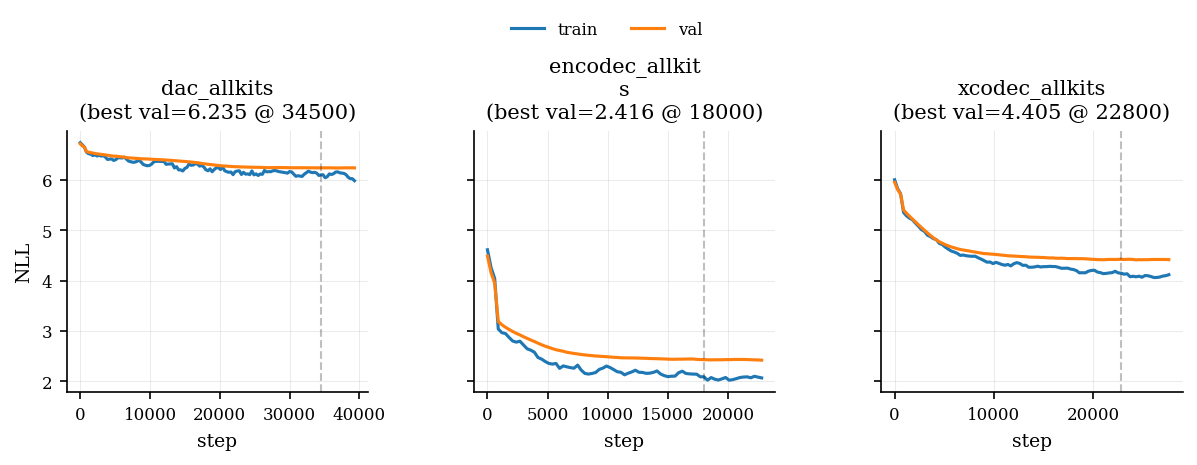

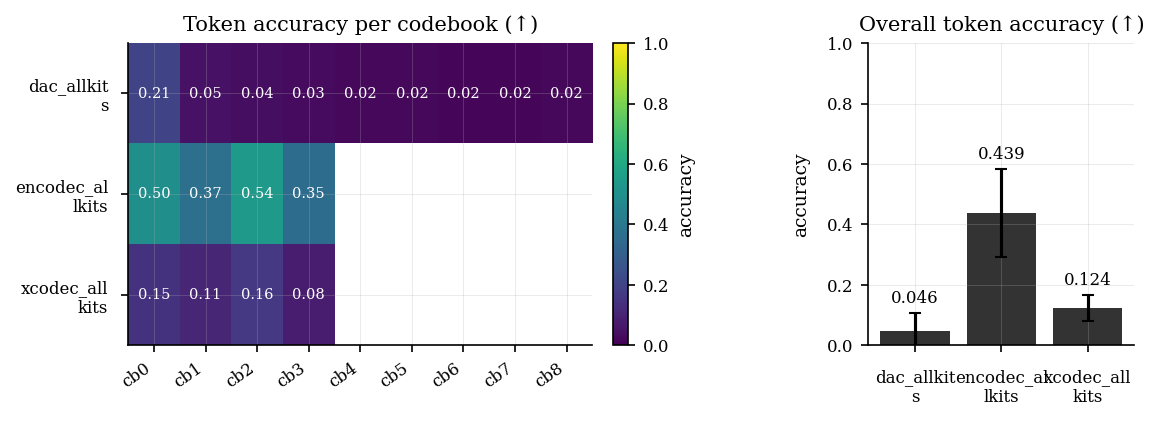

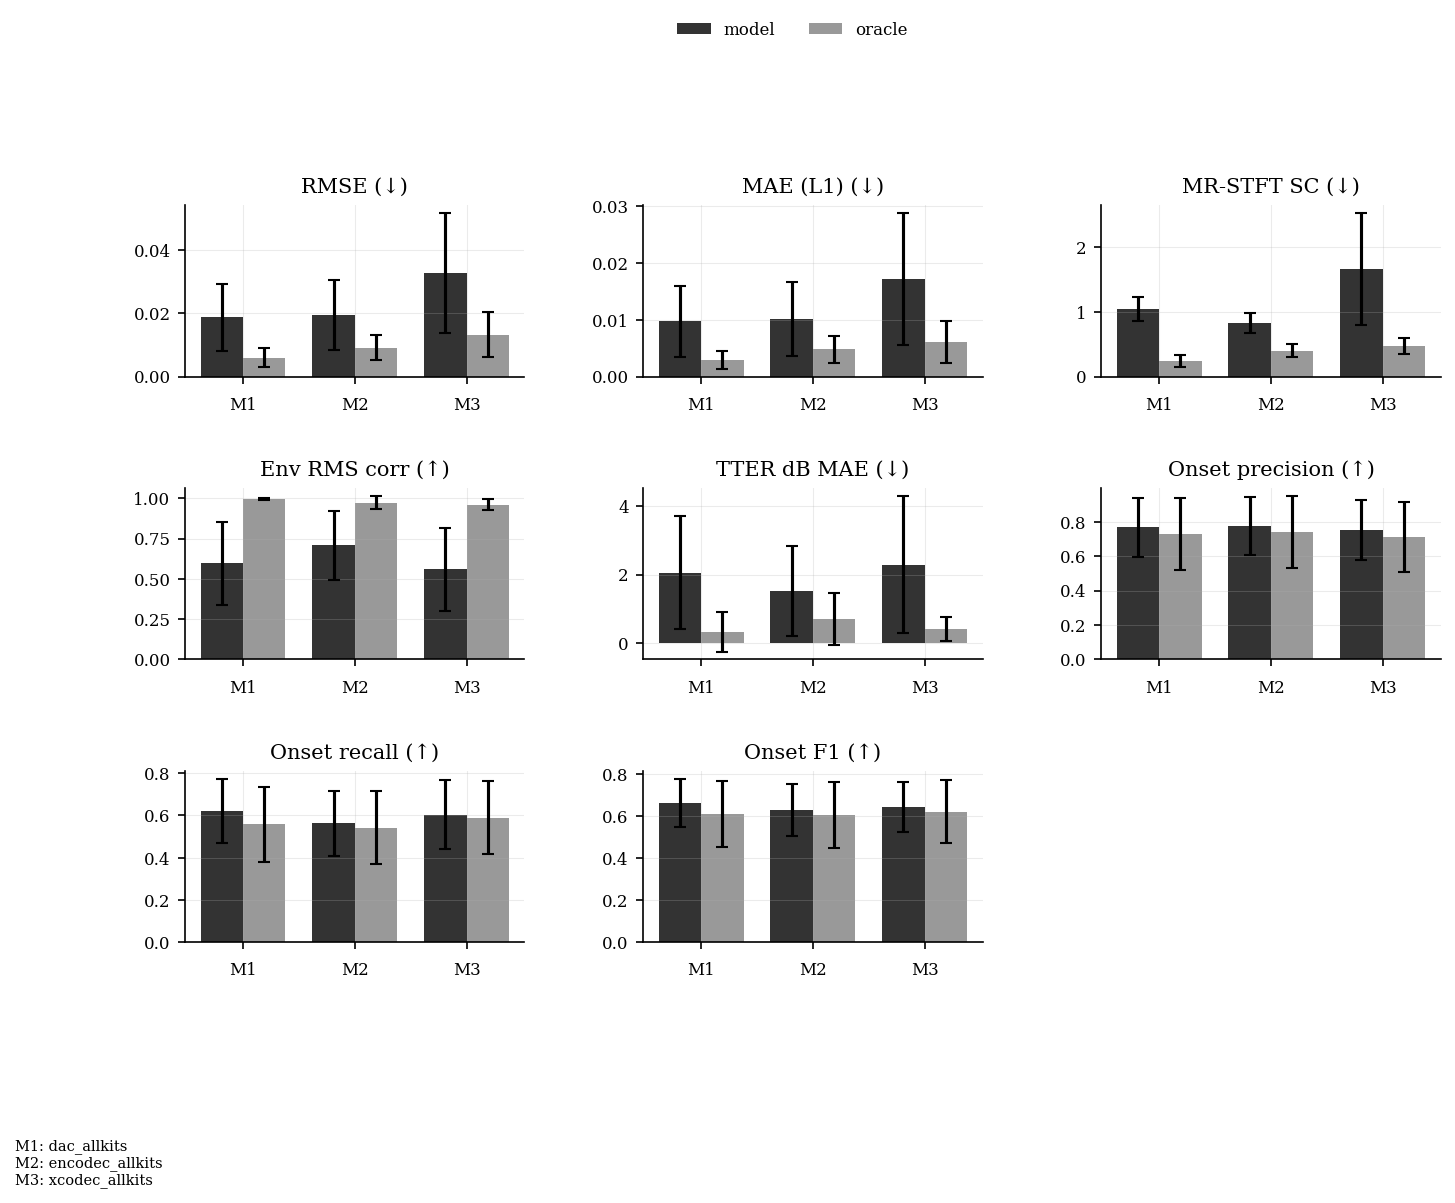

In [4]:
# Notebook snippet: overall plots + overall/per-kit tables (multi-kit compact; single-kit keeps plots)
# FIXES:
# - keep checkpoint-derived names (no overrides)
# - eval.py metrics (no FAD / SI-SDR / onset timing):
#   RMSE, MAE (L1), MR-STFT SC, Env RMS corr, TTER(dB) MAE, Onset P/R/F1 (MIDI-referenced)
# - multi-kit: no per-kit plots; instead:
#   (1) audio metrics table per model (overall)
#   (2) audio metrics table per model+kit
#   (3) summarized kit table (winners + rank-sum)
#   (4) codebook summary per kit per model (pivot + detail + system summary)
#   (5) training plots (+ overall token acc plot)

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

try:
    from IPython.display import display  # notebook-friendly
except Exception:  # pragma: no cover
    display = print

OUT_DIR = Path("artifacts/eval/small_all_kits")  # <-- change
FIG_DIR = OUT_DIR / "paper_figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- Style / IO --------------------

def set_paper_style():
    plt.rcParams.update(
        {
            "figure.dpi": 150,
            "savefig.dpi": 300,
            "font.size": 9,
            "font.family": "DejaVu Serif",
            "axes.titlesize": 10,
            "axes.labelsize": 9,
            "legend.fontsize": 8,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.grid": True,
            "grid.alpha": 0.25,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.5,
        }
    )

def load_eval(out_dir: Path):
    summary = json.loads((out_dir / "summary.json").read_text(encoding="utf-8"))
    items = pd.read_csv(out_dir / "items.csv")
    return summary, items

# -------------------- Labels --------------------

def _paper_model_label_from_stem(stem: str) -> str:
    s = str(stem)
    for prefix in ("expressivegrid_to_", "expressivegrid-to-", "eg_", "eg-"):
        if s.startswith(prefix):
            s = s[len(prefix) :]
    return s.replace("__", "_").strip("_")

def _short_model_label(s: str) -> str:
    return _paper_model_label_from_stem(s)

def _fit_xtick_label(s: str, *, max_chars: int = 22, wrap_at: int = 12) -> str:
    s = str(s)
    if len(s) > max_chars:
        s = s[: max_chars - 1] + "…"
    if len(s) > wrap_at:
        return "\n".join(textwrap.wrap(s, width=wrap_at))
    return s

def base_systems(summary: dict) -> list[str]:
    # preserve eval-run ordering (don’t sort)
    return [k for k in summary["systems"].keys() if not k.endswith(("_oracle", "_random"))]

def ckpt_from_summary(summary: dict, system: str) -> Path | None:
    p = summary["systems"].get(system, {}).get("ckpt")
    return Path(p) if isinstance(p, str) and p else None

def label_for_base(summary: dict, base: str) -> str:
    ckpt = ckpt_from_summary(summary, base)
    return _paper_model_label_from_stem(ckpt.stem) if ckpt is not None else base

def find_train_metrics_csv(summary: dict, system: str) -> Path | None:
    ckpt = ckpt_from_summary(summary, system)
    if ckpt is None:
        return None
    p = Path(str(ckpt) + ".metrics.csv")
    return p if p.is_file() else None

# -------------------- Kits --------------------

def kits_in_items(items: pd.DataFrame) -> list[str]:
    if "kit_name_id" in items.columns:
        df = items[["kit", "kit_name_id"]].drop_duplicates().sort_values("kit_name_id")
        return [str(k) for k in df["kit"].tolist()]
    return sorted([str(k) for k in items["kit"].dropna().unique().tolist()])

# -------------------- Training plots --------------------

def plot_training_grid(summary: dict, systems, labels, fig_dir: Path, smoothing_window: int = 5):
    set_paper_style()
    n = len(systems)
    fig, axes = plt.subplots(1, n, figsize=(3.2 * n, 2.6), sharey=True)
    if n == 1:
        axes = [axes]

    handles = None
    leg_labels = None

    for ax, sys, lab in zip(axes, systems, labels):
        lab_fit = _fit_xtick_label(lab, max_chars=28, wrap_at=14)

        p = find_train_metrics_csv(summary, sys)
        if p is None:
            ax.set_title(f"{lab_fit} (no train log)")
            ax.set_axis_off()
            continue

        df = pd.read_csv(p).sort_values("step")
        best_val = float(df["val_loss"].min()) if "val_loss" in df.columns and len(df) else float("nan")
        best_step = int(df.loc[df["val_loss"].idxmin(), "step"]) if "val_loss" in df.columns and len(df) else None

        x = df["step"].to_numpy()
        tr = df["train_loss"].to_numpy()
        va = df["val_loss"].to_numpy()

        if smoothing_window and smoothing_window > 1 and len(df) >= smoothing_window:
            tr = pd.Series(tr).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()
            va = pd.Series(va).rolling(smoothing_window, center=True, min_periods=1).mean().to_numpy()

        l1, = ax.plot(x, tr, label="train", color="C0")
        l2, = ax.plot(x, va, label="val", color="C1")
        if handles is None:
            handles = [l1, l2]
            leg_labels = ["train", "val"]

        if best_step is not None:
            ax.axvline(best_step, color="k", alpha=0.25, linewidth=1.0, linestyle="--")

        ax.set_title(f"{lab_fit}\n(best val={best_val:.3f}" + (f" @ {best_step}" if best_step is not None else "") + ")")
        ax.set_xlabel("step")
        ax.set_ylabel("NLL" if ax is axes[0] else "")

    if handles is not None:
        fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.10))

    fig.subplots_adjust(top=0.78, wspace=0.35)
    fig.savefig(fig_dir / "training_curves_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "training_curves_grid.png", bbox_inches="tight")
    return fig

# -------------------- Token accuracy plots (overall) --------------------

def token_acc_summary(items: pd.DataFrame):
    cb_cols = [c for c in items.columns if c.startswith("token_acc_cb") and items[c].notna().any()]
    cb_cols = sorted(cb_cols, key=lambda s: int(s.replace("token_acc_cb", "")))
    overall = items.groupby("system")["token_acc"].agg(["mean", "std", "count"]).rename(columns={"count": "n"})
    per_cb_mean = items.groupby("system")[cb_cols].mean() if cb_cols else pd.DataFrame(index=overall.index)
    per_cb_std = items.groupby("system")[cb_cols].std() if cb_cols else pd.DataFrame(index=overall.index)
    return overall, per_cb_mean, per_cb_std, cb_cols

def _text_color_for_value(v: float) -> str:
    return "white" if np.isfinite(v) and v < 0.55 else "black"

def plot_token_acc(
    systems,
    labels,
    overall,
    per_cb_mean,
    cb_cols,
    fig_dir: Path,
    *,
    heatmap_decimals: int = 2,
    bar_decimals: int = 3,
):
    set_paper_style()
    sys_labels = [_fit_xtick_label(_short_model_label(l), max_chars=18, wrap_at=10) for l in labels]

    fig = plt.figure(figsize=(8.6, 3.2))
    if cb_cols:
        gs = fig.add_gridspec(1, 2, width_ratios=[2.1, 1.1])
        ax0 = fig.add_subplot(gs[0, 0])
        ax1 = fig.add_subplot(gs[0, 1])

        heat = per_cb_mean.reindex(systems)[cb_cols]
        arr = heat.to_numpy()
        im = ax0.imshow(arr, aspect="auto", vmin=0.0, vmax=1.0, cmap="viridis")
        ax0.set_title("Token accuracy per codebook (↑)")
        ax0.set_yticks(range(len(systems)))
        ax0.set_yticklabels(sys_labels)
        ax0.set_xticks(range(len(cb_cols)))
        ax0.set_xticklabels([c.replace("token_acc_cb", "cb") for c in cb_cols], rotation=35, ha="right")
        ax0.tick_params(axis="y", pad=6)

        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                v = arr[i, j]
                if not np.isfinite(v):
                    continue
                ax0.text(j, i, f"{v:.{heatmap_decimals}f}", ha="center", va="center", fontsize=7, color=_text_color_for_value(float(v)))

        cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
        cbar.set_label("accuracy")
    else:
        ax1 = fig.add_subplot(1, 1, 1)

    o = overall.reindex(systems)
    x = np.arange(len(systems))
    means = o["mean"].to_numpy()
    stds = o["std"].to_numpy()
    bars = ax1.bar(x, means, yerr=stds, capsize=3, color="0.2")
    ax1.set_title("Overall token accuracy (↑)")
    ax1.set_ylim(0.0, 1.0)
    ax1.set_xticks(x)
    ax1.set_xticklabels(sys_labels, rotation=0, ha="center")
    ax1.set_ylabel("accuracy", labelpad=18)
    ax1.yaxis.set_label_coords(-0.22 if cb_cols else -0.08, 0.5)
    ax1.tick_params(axis="x", pad=8)

    for b, m, s in zip(bars, means, stds):
        if not np.isfinite(m):
            continue
        y = float(m) + (float(s) if np.isfinite(s) else 0.0) + 0.02
        ax1.text(b.get_x() + b.get_width() / 2.0, min(0.98, y), f"{float(m):.{bar_decimals}f}", ha="center", va="bottom", fontsize=8, color="black")

    fig.subplots_adjust(left=0.20 if cb_cols else 0.14, bottom=0.25, right=0.98, wspace=0.60)
    fig.savefig(fig_dir / "token_accuracy_grid.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "token_accuracy_grid.png", bbox_inches="tight")
    return fig

# -------------------- Audio metrics (overall + per kit) --------------------

AUDIO_METRICS = [
    ("rmse",            "RMSE",            "down", 4),
    ("mae",             "MAE (L1)",        "down", 4),
    ("mr_stft_sc",      "MR-STFT SC",      "down", 3),
    ("env_rms_corr",    "Env RMS corr",    "up",   3),
    ("tter_db_mae",     "TTER dB MAE",     "down", 3),
    ("onset_precision", "Onset precision", "up",   3),
    ("onset_recall",    "Onset recall",    "up",   3),
    ("onset_f1",        "Onset F1",        "up",   3),
]

def _arrow_tex(direction: str) -> str:
    return r"$\uparrow$" if direction == "up" else r"$\downarrow$"

def _fmt_mean_std(v, *, decimals: int) -> str:
    if isinstance(v, dict) and "mean" in v:
        m = v.get("mean", None)
        s = v.get("std", None)
        if isinstance(m, (int, float)) and np.isfinite(m):
            if isinstance(s, (int, float)) and np.isfinite(s):
                return f"{m:.{decimals}f} ± {s:.{decimals}f}"
            return f"{m:.{decimals}f}"
    if isinstance(v, (int, float)) and np.isfinite(v):
        return f"{float(v):.{decimals}f}"
    return ""

def _get_metric(summary: dict, system: str, key: str):
    return summary["systems"].get(system, {}).get(key, None)

def _get_per_kit_block(summary: dict, system: str) -> dict:
    sysd = summary["systems"].get(system, {})
    per = sysd.get("per_kit", {})
    return per if isinstance(per, dict) else {}

def _get_metric_per_kit(summary: dict, system: str, kit: str, key: str):
    per = _get_per_kit_block(summary, system)
    kd = per.get(kit, {}) if isinstance(per.get(kit, {}), dict) else {}
    return kd.get(key, None)

def has_any_oracle(summary: dict, bases: list[str]) -> bool:
    return any(f"{b}_oracle" in summary.get("systems", {}) for b in bases)

def audio_table_overall(summary: dict, bases: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    show_oracle = has_any_oracle(summary, bases)

    rows_pretty = []
    rows_csv = []

    for b in bases:
        o = f"{b}_oracle"
        has_oracle = show_oracle and (o in summary["systems"])

        row_pretty = {"model": label_for_base(summary, b)}
        row_csv = {"model": label_for_base(summary, b)}

        for key, disp, direction, dec in AUDIO_METRICS:
            arrow = _arrow_tex(direction)

            v_b = _get_metric(summary, b, key)
            row_pretty[f"{disp} {arrow}"] = _fmt_mean_std(v_b, decimals=dec)
            row_csv[key] = _fmt_mean_std(v_b, decimals=dec)

            if show_oracle:
                v_o = _get_metric(summary, o, key) if has_oracle else None
                row_pretty[f"{disp} (oracle) {arrow}"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""
                row_csv[f"{key}_oracle"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""

        rows_pretty.append(row_pretty)
        rows_csv.append(row_csv)

    tbl_pretty = pd.DataFrame(rows_pretty).set_index("model")
    tbl_csv = pd.DataFrame(rows_csv).set_index("model")
    return tbl_pretty, tbl_csv

def audio_table_per_model_kit(summary: dict, items: pd.DataFrame, bases: list[str], kits: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Table indexed by (kit, model). Uses eval.py summary per_kit if present; otherwise falls back to items.csv aggregation.
    """
    show_oracle = has_any_oracle(summary, bases)
    rows_pretty = []
    rows_csv = []

    # fast path: use per_kit from summary if it exists for at least one model
    any_per_kit = any(bool(_get_per_kit_block(summary, b)) for b in bases)

    if any_per_kit:
        # n per kit: use items.csv counts (more robust)
        kit_counts = items.groupby("kit").size().to_dict()

        for kit in kits:
            for b in bases:
                o = f"{b}_oracle"
                has_oracle = show_oracle and (o in summary["systems"])

                row_pretty = {"kit": kit, "model": label_for_base(summary, b), "n": int(kit_counts.get(kit, 0))}
                row_csv = {"kit": kit, "model": label_for_base(summary, b), "n": int(kit_counts.get(kit, 0))}

                for key, disp, direction, dec in AUDIO_METRICS:
                    arrow = _arrow_tex(direction)

                    v_b = _get_metric_per_kit(summary, b, kit, key)
                    row_pretty[f"{disp} {arrow}"] = _fmt_mean_std(v_b, decimals=dec)
                    row_csv[key] = _fmt_mean_std(v_b, decimals=dec)

                    if show_oracle:
                        v_o = _get_metric_per_kit(summary, o, kit, key) if has_oracle else None
                        row_pretty[f"{disp} (oracle) {arrow}"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""
                        row_csv[f"{key}_oracle"] = _fmt_mean_std(v_o, decimals=dec) if has_oracle else ""

                rows_pretty.append(row_pretty)
                rows_csv.append(row_csv)
    else:
        # fallback: compute mean/std per kit/system from items.csv
        cols = [k for (k, _, _, _) in AUDIO_METRICS if k in items.columns]
        kit_counts = items.groupby("kit").size().to_dict()

        g = items[items["system"].isin(bases)].groupby(["kit", "system"])
        means = g[cols].mean()
        stds = g[cols].std()

        for kit in kits:
            for b in bases:
                mname = label_for_base(summary, b)
                row_pretty = {"kit": kit, "model": mname, "n": int(kit_counts.get(kit, 0))}
                row_csv = {"kit": kit, "model": mname, "n": int(kit_counts.get(kit, 0))}

                for key, disp, direction, dec in AUDIO_METRICS:
                    arrow = _arrow_tex(direction)
                    if key not in cols:
                        row_pretty[f"{disp} {arrow}"] = ""
                        row_csv[key] = ""
                        continue
                    try:
                        mu = float(means.loc[(kit, b), key])
                    except Exception:
                        mu = float("nan")
                    try:
                        sd = float(stds.loc[(kit, b), key])
                    except Exception:
                        sd = float("nan")

                    if np.isfinite(mu) and np.isfinite(sd):
                        s = f"{mu:.{dec}f} ± {sd:.{dec}f}"
                    elif np.isfinite(mu):
                        s = f"{mu:.{dec}f}"
                    else:
                        s = ""
                    row_pretty[f"{disp} {arrow}"] = s
                    row_csv[key] = s

                rows_pretty.append(row_pretty)
                rows_csv.append(row_csv)

    tbl_pretty = pd.DataFrame(rows_pretty).set_index(["kit", "model"]).sort_index()
    tbl_csv = pd.DataFrame(rows_csv).set_index(["kit", "model"]).sort_index()
    return tbl_pretty, tbl_csv

# -------------------- Kit summary table (winners + rank-sum) --------------------

def kit_summary_table(summary: dict, items: pd.DataFrame, bases: list[str], kits: list[str]) -> pd.DataFrame:
    """
    For each kit:
      - n items
      - winner per metric
      - overall winner by rank-sum across AUDIO_METRICS (ignoring NaNs)
    """
    # Build a (kit, system) -> metric_mean table from summary per_kit if available, else from items.
    any_per_kit = any(bool(_get_per_kit_block(summary, b)) for b in bases)
    kit_counts = items.groupby("kit").size().to_dict()

    kit_sys_mean = []
    if any_per_kit:
        for kit in kits:
            for sys in bases:
                row = {"kit": kit, "system": sys}
                for key, _, _, _ in AUDIO_METRICS:
                    v = _get_metric_per_kit(summary, sys, kit, key)
                    mu = v.get("mean") if isinstance(v, dict) else (float(v) if isinstance(v, (int, float)) else np.nan)
                    row[key] = float(mu) if isinstance(mu, (int, float)) and np.isfinite(mu) else np.nan
                kit_sys_mean.append(row)
        df = pd.DataFrame(kit_sys_mean)
    else:
        cols = [k for (k, _, _, _) in AUDIO_METRICS if k in items.columns]
        g = items[items["system"].isin(bases)].groupby(["kit", "system"])[cols].mean().reset_index()
        df = g

    out_rows = []
    for kit in kits:
        row = {"kit": kit, "n": int(kit_counts.get(kit, 0))}
        sub = df[df["kit"] == kit].set_index("system")

        # rank-sum (lower is better)
        rank_sum = None
        for key, _, direction, _ in AUDIO_METRICS:
            if key not in sub.columns:
                continue
            s = sub[key]
            if direction == "up":
                r = (-s).rank(method="min", na_option="keep")
            else:
                r = (s).rank(method="min", na_option="keep")
            rank_sum = r if rank_sum is None else (rank_sum + r)

        if rank_sum is not None and rank_sum.notna().any():
            winner = str(rank_sum.idxmin())
            row["overall_winner"] = label_for_base(summary, winner)
            row["overall_rank_sum"] = float(rank_sum.min())
        else:
            row["overall_winner"] = ""
            row["overall_rank_sum"] = ""

        # per-metric winners
        for key, disp, direction, dec in AUDIO_METRICS:
            if key not in sub.columns:
                row[f"{key}_winner"] = ""
                row[f"{key}_best"] = ""
                continue
            s = sub[key]
            if direction == "up":
                best_sys = s.idxmax() if s.notna().any() else None
                best_val = float(s.max()) if s.notna().any() else np.nan
            else:
                best_sys = s.idxmin() if s.notna().any() else None
                best_val = float(s.min()) if s.notna().any() else np.nan
            row[f"{key}_winner"] = label_for_base(summary, best_sys) if best_sys is not None else ""
            row[f"{key}_best"] = f"{best_val:.{dec}f}" if np.isfinite(best_val) else ""

        out_rows.append(row)

    out = pd.DataFrame(out_rows).set_index("kit")
    return out

# -------------------- Codebook summary per kit per model --------------------

def codebook_summary_per_kit_per_model(items: pd.DataFrame, bases: list[str]) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      - kit_cb_mean_pivot: kit x system (macro-avg across codebooks)
      - kit_cb_detail_long: (kit, system) rows with cb_mean/cb_min/cb_max + per-cb means
      - system_cb_summary: system-level summary across kits (mean/median/p25/p75 + win counts)
    """
    cb_cols = [c for c in items.columns if c.startswith("token_acc_cb") and items[c].notna().any()]
    cb_cols = sorted(cb_cols, key=lambda s: int(s.replace("token_acc_cb", "")))
    if not cb_cols:
        empty = pd.DataFrame()
        return empty, empty, empty

    g = (
        items[items["system"].isin(bases)]
        .groupby(["kit", "system"])[cb_cols]
        .mean()
        .reset_index()
    )
    g["cb_mean"] = g[cb_cols].mean(axis=1)
    g["cb_min"] = g[cb_cols].min(axis=1)
    g["cb_max"] = g[cb_cols].max(axis=1)

    kit_order = kits_in_items(items)
    kit_cb_mean_pivot = g.pivot(index="kit", columns="system", values="cb_mean").reindex(index=kit_order, columns=bases)

    winners = kit_cb_mean_pivot.idxmax(axis=1)
    losers = kit_cb_mean_pivot.idxmin(axis=1)

    def _q(s: pd.Series, q: float) -> float:
        a = s.to_numpy(dtype=float)
        a = a[np.isfinite(a)]
        return float(np.quantile(a, q)) if a.size else float("nan")

    rows = []
    for sys in bases:
        s = kit_cb_mean_pivot[sys]
        rows.append(
            {
                "system": sys,
                "kits": int(s.notna().sum()),
                "cb_mean_mean": float(s.mean()),
                "cb_mean_median": float(s.median()),
                "cb_mean_p25": _q(s, 0.25),
                "cb_mean_p75": _q(s, 0.75),
                "best_kits": int((winners == sys).sum()),
                "worst_kits": int((losers == sys).sum()),
            }
        )
    system_cb_summary = pd.DataFrame(rows).set_index("system")
    kit_cb_detail_long = g.set_index(["kit", "system"]).sort_index()
    return kit_cb_mean_pivot, kit_cb_detail_long, system_cb_summary

# -------------------- Overall audio bar plot (per model only) --------------------

def plot_audio_metrics_overall(summary: dict, bases: list[str], fig_dir: Path):
    set_paper_style()

    # Full checkpoint-derived names
    full = [label_for_base(summary, b) for b in bases]
    # Short IDs
    short = [f"M{i+1}" for i in range(len(bases))]
    # mapping
    map_lines = ["Model ID mapping:"]
    for s, f in zip(short, full):
        map_lines.append(f"  {s}: {f}")
    (fig_dir / "model_id_mapping.txt").write_text("\n".join(map_lines) + "\n", encoding="utf-8")

    x = np.arange(len(bases))
    n_metrics = len(AUDIO_METRICS)
    ncols = 3
    nrows = int(np.ceil(n_metrics / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3.6 * ncols, 2.6 * nrows), squeeze=False)

    show_oracle = has_any_oracle(summary, bases)

    for idx, (key, disp, direction, _dec) in enumerate(AUDIO_METRICS):
        ax = axes[idx // ncols][idx % ncols]
        arrow = "↑" if direction == "up" else "↓"

        means_b, stds_b = [], []
        means_o, stds_o = [], []

        def _ms(v):
            if isinstance(v, dict) and isinstance(v.get("mean"), (int, float)) and np.isfinite(v["mean"]):
                m = float(v["mean"])
                s = float(v.get("std")) if isinstance(v.get("std"), (int, float)) and np.isfinite(v.get("std")) else 0.0
                return m, s
            if isinstance(v, (int, float)) and np.isfinite(v):
                return float(v), 0.0
            return np.nan, 0.0

        for b in bases:
            vb = _get_metric(summary, b, key)
            mb, sb = _ms(vb)
            means_b.append(mb); stds_b.append(sb)

            if show_oracle and (f"{b}_oracle" in summary["systems"]):
                vo = _get_metric(summary, f"{b}_oracle", key)
                mo, so = _ms(vo)
            else:
                mo, so = np.nan, 0.0
            means_o.append(mo); stds_o.append(so)

        means_b = np.asarray(means_b, dtype=float)
        stds_b = np.asarray(stds_b, dtype=float)

        ax.set_title(f"{disp} ({arrow})")
        ax.set_xticks(x)
        ax.set_xticklabels(short, rotation=0, ha="center")
        ax.tick_params(axis="x", pad=6)

        if show_oracle:
            means_o = np.asarray(means_o, dtype=float)
            stds_o = np.asarray(stds_o, dtype=float)
            w = 0.38
            ax.bar(x - w/2, means_b, w, yerr=stds_b, capsize=3, label="model", color="0.2")
            ax.bar(x + w/2, means_o, w, yerr=stds_o, capsize=3, label="oracle", color="0.6")
        else:
            ax.bar(x, means_b, 0.55, yerr=stds_b, capsize=3, label="model", color="0.2")

    for j in range(n_metrics, nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    handles, leg_labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, leg_labels, frameon=False, loc="upper center", ncol=len(leg_labels), bbox_to_anchor=(0.5, 1.02))

    map_text = "\n".join([f"{s}: {f}" for s, f in zip(short, full)])
    fig.text(0.02, 0.01, map_text, ha="left", va="bottom", fontsize=7)

    fig.subplots_adjust(top=0.85, hspace=0.65, wspace=0.35, bottom=0.22)
    fig.savefig(fig_dir / "audio_metrics_overall_bars.pdf", bbox_inches="tight")
    fig.savefig(fig_dir / "audio_metrics_overall_bars.png", bbox_inches="tight")
    return fig

# -------------------- Run --------------------

summary, items = load_eval(OUT_DIR)
bases = base_systems(summary)
kits = kits_in_items(items)

# (5) Training plots
plot_training_grid(summary, bases, [label_for_base(summary, b) for b in bases], FIG_DIR, smoothing_window=5)

# Overall token plots (kept for single + multi-kit; only depends on #models)
overall, per_cb_mean, per_cb_std, cb_cols = token_acc_summary(items)
plot_token_acc(bases, [label_for_base(summary, b) for b in bases], overall, per_cb_mean, cb_cols, FIG_DIR)

# Overall audio plots (per model only)
plot_audio_metrics_overall(summary, bases, FIG_DIR)

# (1) Audio metrics table per model (overall)
tbl_audio_pretty, tbl_audio_csv = audio_table_overall(summary, bases)
display(tbl_audio_pretty)
suffix = "_with_oracle" if has_any_oracle(summary, bases) else "_no_oracle"
tbl_audio_pretty.to_latex(FIG_DIR / f"audio_table_overall{suffix}.tex", escape=False)
tbl_audio_csv.to_csv(FIG_DIR / f"audio_table_overall{suffix}.csv")
tbl_audio_pretty.to_csv(FIG_DIR / f"audio_table_overall_pretty{suffix}.csv")

# (2) Audio metrics table per model and kit
tbl_audio_kit_pretty, tbl_audio_kit_csv = audio_table_per_model_kit(summary, items, bases, kits)
display(tbl_audio_kit_pretty)  # big, notebook will scroll
tbl_audio_kit_pretty.to_latex(FIG_DIR / f"audio_table_per_kit{suffix}.tex", escape=False, multirow=True)
tbl_audio_kit_csv.to_csv(FIG_DIR / f"audio_table_per_kit{suffix}.csv")
tbl_audio_kit_pretty.to_csv(FIG_DIR / f"audio_table_per_kit_pretty{suffix}.csv")

# (3) Summarized kit table (winners + rank-sum across metrics)
tbl_kit_summary = kit_summary_table(summary, items, bases, kits)
display(tbl_kit_summary)
tbl_kit_summary.to_csv(FIG_DIR / "kit_summary.csv")
tbl_kit_summary.to_latex(FIG_DIR / "kit_summary.tex", escape=False)

# (4) Codebook summarization per kit per model (no per-kit plots)
kit_cb_mean_pivot, kit_cb_detail_long, system_cb_summary = codebook_summary_per_kit_per_model(items, bases)
display(system_cb_summary)

kit_cb_mean_pivot.to_csv(FIG_DIR / "codebook_cb_mean_per_kit_pivot.csv")
kit_cb_detail_long.to_csv(FIG_DIR / "codebook_cb_detail_per_kit_system.csv")
system_cb_summary.to_csv(FIG_DIR / "codebook_system_summary.csv")

# Optional: also export LaTeX for the compact summaries
system_cb_summary.to_latex(FIG_DIR / "codebook_system_summary.tex", escape=False)
# (pivot is often too wide for LaTeX; keep CSV)

print("Wrote:", FIG_DIR)


# FAD check

In [ ]:
# Sanity checks for FAD(PANN): does it separate obvious wrong audio?
# - FAD(ref, ref) should be ~0
# - FAD(ref, pred) should be > 0
# - FAD(ref, shuffled_pred) should be >= FAD(ref, pred)
# - FAD(ref, noise) should be much larger than ref/pred
# - FAD(ref, oracle) should usually be <= FAD(ref, pred)

from pathlib import Path
import random
import shutil
import numpy as np

from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")  # <-- change
SYS = "encodec"  # <-- change: "dac" | "encodec" | "xcodec"
EVAL_SR = 32000  # <-- must match what eval saved

ref_dir    = RUN / "ref_by_system" / SYS
pred_dir   = RUN / "pred" / SYS
oracle_dir = RUN / "oracle" / SYS

assert ref_dir.is_dir(), ref_dir
assert pred_dir.is_dir(), pred_dir

fad = FrechetAudioDistance(
    model_name="pann",
    sample_rate=int(EVAL_SR),
    use_pca=False,
    use_activation=False,
    verbose=False,
)

def _list_wavs(d: Path):
    return sorted([p for p in d.rglob("*.wav") if p.is_file()])

def _make_clean_dir(d: Path):
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

def _copy_subset(src: Path, dst: Path, wavs: list[Path]):
    _make_clean_dir(dst)
    for p in wavs:
        rel = p.relative_to(src)
        out = dst / rel
        out.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(p, out)

def _shuffled_pred_subset(ref_wavs: list[Path], pred_wavs: list[Path], dst: Path):
    # copy preds but with filenames matching refs (pairing wrong items)
    _make_clean_dir(dst)
    pred_shuf = pred_wavs[:]
    random.shuffle(pred_shuf)
    for r, p in zip(ref_wavs, pred_shuf):
        out = dst / r.name  # flatten OK for FAD
        shutil.copy2(p, out)

def _noise_like_ref_subset(ref_wavs: list[Path], dst: Path):
    # white noise with same length as each ref file (requires soundfile)
    import soundfile as sf
    _make_clean_dir(dst)
    rng = np.random.default_rng(0)
    for r in ref_wavs:
        y, sr = sf.read(r, dtype="float32", always_2d=False)
        assert int(sr) == int(EVAL_SR), (sr, EVAL_SR, r)
        if y.ndim > 1:
            y = y.mean(axis=-1)
        n = rng.standard_normal(size=y.shape[0]).astype("float32")
        # match RMS roughly
        rms_y = float(np.sqrt(np.mean(np.square(y)) + 1e-12))
        rms_n = float(np.sqrt(np.mean(np.square(n)) + 1e-12))
        n = n * (rms_y / max(1e-8, rms_n))
        sf.write(dst / r.name, n, int(EVAL_SR))

def score(a: Path, b: Path) -> float:
    return float(fad.score(str(a), str(b), dtype="float32"))

# ---- run checks on a subset for speed ----
ref_wavs  = _list_wavs(ref_dir)
pred_wavs = _list_wavs(pred_dir)
assert len(ref_wavs) == len(pred_wavs), (len(ref_wavs), len(pred_wavs))

N = min(512, len(ref_wavs))  # <-- increase for stability
random.seed(0)
idx = random.sample(range(len(ref_wavs)), k=N)
ref_sub  = [ref_wavs[i] for i in idx]
pred_sub = [pred_wavs[i] for i in idx]

TMP = RUN / "fad_sanity_tmp" / SYS
ref_tmp     = TMP / "ref"
pred_tmp    = TMP / "pred"
shuf_tmp    = TMP / "pred_shuffled"
noise_tmp   = TMP / "noise"
oracle_tmp  = TMP / "oracle"

_copy_subset(ref_dir, ref_tmp, ref_sub)
_copy_subset(pred_dir, pred_tmp, pred_sub)
_shuffled_pred_subset(ref_sub, pred_sub, shuf_tmp)
_noise_like_ref_subset(ref_sub, noise_tmp)

print(f"Subset N={N} @ sr={EVAL_SR} sys={SYS}")
fad_ref_ref   = score(ref_tmp, ref_tmp)
fad_ref_pred  = score(ref_tmp, pred_tmp)
fad_ref_shuf  = score(ref_tmp, shuf_tmp)
fad_ref_noise = score(ref_tmp, noise_tmp)

print(f"FAD(ref, ref)        = {fad_ref_ref:.8e}")
print(f"FAD(ref, pred)       = {fad_ref_pred:.8e}")
print(f"FAD(ref, shuffled)   = {fad_ref_shuf:.8e}")
print(f"FAD(ref, noise)      = {fad_ref_noise:.8e}")

if oracle_dir.is_dir():
    oracle_wavs = _list_wavs(oracle_dir)
    if len(oracle_wavs) >= N:
        oracle_sub = [oracle_wavs[i] for i in idx]
        _copy_subset(oracle_dir, oracle_tmp, oracle_sub)
        fad_ref_oracle = score(ref_tmp, oracle_tmp)
        print(f"FAD(ref, oracle)     = {fad_ref_oracle:.8e}")
    else:
        print("Oracle present but not enough wavs for subset.")

print("Tmp written to:", TMP)


In [ ]:
# Optional: check if FAD is mostly driven by loudness (RMS) mismatch
# (If FAD barely changes after RMS-normalizing, it’s not sensitive to your errors.)

from pathlib import Path
import numpy as np
import shutil
import soundfile as sf
from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")  # <-- change
SYS = "encodec"
EVAL_SR = 32000

ref_dir  = RUN / "ref_by_system" / SYS
pred_dir = RUN / "pred" / SYS

fad = FrechetAudioDistance(model_name="pann", sample_rate=int(EVAL_SR), use_pca=False, use_activation=False, verbose=False)

def _list_wavs(d: Path):
    return sorted([p for p in d.rglob("*.wav") if p.is_file()])

def _make_clean_dir(d: Path):
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

def _rms_normalize_tree(src: Path, dst: Path, target_rms: float = 0.05):
    _make_clean_dir(dst)
    for p in _list_wavs(src):
        y, sr = sf.read(p, dtype="float32", always_2d=False)
        assert int(sr) == int(EVAL_SR), (sr, EVAL_SR, p)
        if y.ndim > 1:
            y = y.mean(axis=-1)
        rms = float(np.sqrt(np.mean(np.square(y)) + 1e-12))
        y = y * (float(target_rms) / max(1e-8, rms))
        out = dst / p.name
        sf.write(out, y, int(EVAL_SR))

TMP = RUN / "fad_rms_tmp" / SYS
ref_n = TMP / "ref_norm"
pred_n = TMP / "pred_norm"

ref = RUN / "fad_sanity_tmp" / SYS / "ref"     # reuse subset from previous snippet if present
pred = RUN / "fad_sanity_tmp" / SYS / "pred"

if not ref.is_dir():
    ref = ref_dir
if not pred.is_dir():
    pred = pred_dir

_rms_normalize_tree(ref, ref_n, target_rms=0.05)
_rms_normalize_tree(pred, pred_n, target_rms=0.05)

fad_raw = float(fad.score(str(ref), str(pred), dtype="float32"))
fad_norm = float(fad.score(str(ref_n), str(pred_n), dtype="float32"))

print(f"FAD raw  = {fad_raw:.8e}")
print(f"FAD norm = {fad_norm:.8e}")
print("Tmp written to:", TMP)


In [ ]:
# 1) Verify the "noise" files are actually noise (not accidentally refs)
import numpy as np
import soundfile as sf
from pathlib import Path

RUN = Path("artifacts/pred/small_one_kit")
SYS = "encodec"
ref_dir  = RUN / "fad_sanity_tmp" / SYS / "ref"
noise_dir = RUN / "fad_sanity_tmp" / SYS / "noise"

p = sorted(ref_dir.glob("*.wav"))[0]
r, sr = sf.read(p, dtype="float32")
n, sr2 = sf.read(noise_dir / p.name, dtype="float32")
m = min(len(r), len(n))
r = r[:m]; n = n[:m]

print("sr:", sr, sr2)
print("rms ref  :", float(np.sqrt(np.mean(r*r) + 1e-12)))
print("rms noise:", float(np.sqrt(np.mean(n*n) + 1e-12)))
print("corr(ref,noise):", float(np.corrcoef(r, n)[0,1]))
print("max|ref-noise|:", float(np.max(np.abs(r - n))))


In [ ]:
# 2) Make more extreme baselines: silence + full-scale noise (no RMS matching)
#    Expect: FAD(ref, silence) and FAD(ref, loud_noise) >> FAD(ref, pred)
import numpy as np
import soundfile as sf
import shutil
from pathlib import Path
from frechet_audio_distance import FrechetAudioDistance

RUN = Path("artifacts/pred/small_one_kit")
SYS = "encodec"
EVAL_SR = 32000

ref_tmp = RUN / "fad_sanity_tmp" / SYS / "ref"
sil_dir = RUN / "fad_sanity_tmp" / SYS / "silence"
ln_dir  = RUN / "fad_sanity_tmp" / SYS / "loud_noise"

def clean(d: Path):
    if d.exists(): shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

clean(sil_dir); clean(ln_dir)

for p in sorted(ref_tmp.glob("*.wav")):
    y, sr = sf.read(p, dtype="float32")
    assert int(sr) == int(EVAL_SR)
    sf.write(sil_dir / p.name, np.zeros_like(y), int(EVAL_SR))
    # loud full-scale noise (no RMS match)
    rng = np.random.default_rng(0)
    n = rng.standard_normal(size=y.shape).astype("float32")
    n = n / (np.max(np.abs(n)) + 1e-8) * 0.95
    sf.write(ln_dir / p.name, n, int(EVAL_SR))

fad = FrechetAudioDistance(model_name="pann", sample_rate=int(EVAL_SR), use_pca=False, use_activation=False, verbose=False)
print("FAD(ref, silence)   =", float(fad.score(str(ref_tmp), str(sil_dir), dtype="float32")))
print("FAD(ref, loud_noise)=", float(fad.score(str(ref_tmp), str(ln_dir), dtype="float32")))


In [ ]:

import zipfile
from pathlib import Path
import numpy as np

CACHE = Path("cache/dac_allkits")
bad = []
for p in sorted((CACHE/"items").glob("*.npz")):
    try:
        with np.load(p, allow_pickle=False) as d:
            _ = d.files
    except Exception as e:
        if isinstance(e, zipfile.BadZipFile) or "BadZipFile" in str(e):
            bad.append(p)
print("bad:", len(bad))
for p in bad[:50]:
    print(p)



In [ ]:

import zipfile
from pathlib import Path
import numpy as np

CACHE = Path("cache/dac_allkits")
bad = []
for p in sorted((CACHE/"items").glob("*.npz")):
    try:
        with np.load(p, allow_pickle=False) as d:
            _ = d.files
    except Exception as e:
        if isinstance(e, zipfile.BadZipFile) or "BadZipFile" in str(e):
            bad.append(p)
for p in bad:
    p.unlink(missing_ok=True)
print("deleted:", len(bad))

